In [75]:
import numpy as np
import random
import sklearn.linear_model as linear
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [13]:
databasePath = "../eICU/training/"
exportPath = "../eICU/training/"

In [14]:
finalFeatures = pd.read_csv(databasePath + '/finalFeatures.csv')
finalFeatures = finalFeatures.fillna(0) # fills nan from kurtosis and skew
finalFeatures

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
0,1412030,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,68.0,120.0,...,-1.4140,0.6875,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
1,1412271,37.6965,38.1204,38.0819,0.1278,11.0000,-3.3166,38.1204,103.0,112.0,...,0.2131,1.4000,2.4331,2.4331,2.4331,0.0000,0.0000,0.0000,2.4331,1.0
2,1412290,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,75.0,...,0.1274,1.2345,4.4543,4.4543,4.4543,0.0000,0.0000,0.0000,4.4543,0.0
3,1412660,37.4000,38.0000,37.7832,0.1822,-0.3726,-0.6013,37.8000,84.0,109.0,...,-0.5963,1.6136,0.8306,3.7375,3.6347,0.4814,21.5211,-4.7383,3.7375,0.0
4,1412840,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,70.0,106.0,...,-0.0575,1.0584,0.6420,1.7976,1.5475,0.2748,2.0620,-1.6282,1.5956,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199338,33532516,32.2000,37.7000,35.3112,2.1057,-1.7574,-0.2178,36.6000,51.0,104.0,...,-0.0645,2.6469,0.0980,5.6373,1.0889,0.9895,3.4195,1.6831,0.8171,1.0
199339,33532517,32.2000,37.4000,34.5467,1.8862,-1.7703,0.2656,33.4000,51.0,104.0,...,0.1481,2.5493,0.0980,5.6373,0.9832,1.0570,3.9619,1.9491,0.6334,1.0
199340,33532518,32.2000,36.8000,34.1643,1.7398,-1.4068,0.6213,33.1000,60.0,104.0,...,0.0064,2.4888,0.0980,5.6373,1.0385,1.1231,2.9569,1.7434,0.6010,1.0
199341,33532540,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,72.0,83.0,...,-2.1039,2.2769,0.3576,19.0703,3.7475,2.6719,13.1009,3.2470,2.3838,0.0


#### Cleaning data and Sorting to Input and Target Arrays

In [15]:
x = [] # input (attributes)
y = [] # output (targets)

x = finalFeatures.iloc[:, 1:57].values
y = finalFeatures.iloc[:, 57].values


#### Setting up Models for Neural Network

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()

    def forward(self, x):
        return None

    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)

    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.cpu().detach().numpy()
        return res

    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs > threshold

    def fit(self, x_train, x_test, y_train, y_test, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        train_loss_curve = []
        test_loss_curve = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            train_loss_val = self.loss(x_train, y_train) + self.regularize(lam)
            train_loss_curve.append(train_loss_val.data.item())
            train_loss_val.backward()
            optimizer.step()
            
            test_loss_val = self.loss(x_test, y_test) + self.regularize(lam)
            test_loss_curve.append(test_loss_val.data.item())
            
            if epoch % 500 == 0:
                print(f'Epoch {epoch}, Train Loss: {train_loss_val:.5f}, Test Loss: {test_loss_val:.5f}')
            
            
        return train_loss_curve, test_loss_curve

    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [17]:
class NNModel(Model):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(56, 113, bias=True)
        self.act1 = nn.PReLU()
        self.l2 = nn.Linear(113, 56, bias=True)
        self.act2 = nn.PReLU()
        self.l3 = nn.Linear(56, 1, bias=True)
        self.act3 = nn.Sigmoid()

    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)

        return res

    def forward(self, X):
        res = self.get_intermediary(X)
        res = self.l3(res)
        res = self.act3(res)
        return res

#### Applying Logistic Regression and Neural Network Model

In [18]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [60]:
def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

In [62]:
kf = selection.KFold(n_splits=2, shuffle=True)
kf.get_n_splits(x)

f1_lr = []
f1_nn = []
f1_rf = []
f1_gnb = []
f1_rand = []

precision_lr = []
precision_nn = []
precision_rf = []
precision_gnb = []
precision_rand = []

accuracy_lr = []
accuracy_nn = []
accuracy_rf = []
accuracy_gnb = []
accuracy_rand = []

recall_lr = []
recall_nn = []
recall_rf = []
recall_gnb = []
recall_rand = []

ras_lr = []
ras_nn = []
ras_rf = []
ras_gnb = []
ras_rand = []

train_curve = []
test_curve = []

def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1_lr.append(metrics.f1_score(y_test, predictions))
    precision_lr.append(metrics.precision_score(y_test, predictions))
    accuracy_lr.append(metrics.accuracy_score(y_test, predictions))
    recall_lr.append(metrics.recall_score(y_test, predictions))
    ras_lr.append(metrics.roc_auc_score(y_test, predictions))
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    probs = rf.predict_proba(X_test)[:,1]
    f1_rf.append(metrics.f1_score(y_test, predictions))
    precision_rf.append(metrics.precision_score(y_test, predictions))
    accuracy_rf.append(metrics.accuracy_score(y_test, predictions))
    recall_rf.append(metrics.recall_score(y_test, predictions))
    ras_rf.append(metrics.roc_auc_score(y_test, predictions))
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictions = gnb.predict(X_test)
    probs = gnb.predict_proba(X_test)[:,1]
    f1_gnb.append(metrics.f1_score(y_test, predictions))
    precision_gnb.append(metrics.precision_score(y_test, predictions))
    accuracy_gnb.append(metrics.accuracy_score(y_test, predictions))
    recall_gnb.append(metrics.recall_score(y_test, predictions))
    ras_gnb.append(metrics.roc_auc_score(y_test, predictions))
    
    predictions = random_guessing(X_test)
    f1_rand.append(metrics.f1_score(y_test, predictions))
    precision_rand.append(metrics.precision_score(y_test, predictions))
    accuracy_rand.append(metrics.accuracy_score(y_test, predictions))
    recall_rand.append(metrics.recall_score(y_test, predictions))
    ras_rand.append(metrics.roc_auc_score(y_test, predictions))
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    nn1 = NNModel()
    nn1.to(device)

    train_loss, test_loss = nn1.fit(X_train, X_test, y_train, y_test, epochs=4000, lr=0.0002, lam=0.0001)
    
    train_curve.append(train_loss)
    test_curve.append(test_loss)
    
    predictions = nn1.predict(X_test, as_numpy=True)
    probs = nn1.predict_proba(X_test, as_numpy=True)
    
    f1_nn.append(metrics.f1_score(y_test.cpu(), predictions))
    precision_nn.append(metrics.precision_score(y_test.cpu(), predictions))
    accuracy_nn.append(metrics.accuracy_score(y_test.cpu(), predictions))
    recall_nn.append(metrics.recall_score(y_test.cpu(), predictions))
    ras_nn.append(metrics.roc_auc_score(y_test.cpu(), predictions))

Epoch 0, Train Loss: 0.70043, Test Loss: 0.69143
Epoch 500, Train Loss: 0.34147, Test Loss: 0.33700
Epoch 1000, Train Loss: 0.24200, Test Loss: 0.23439
Epoch 1500, Train Loss: 0.20518, Test Loss: 0.19645
Epoch 2000, Train Loss: 0.18957, Test Loss: 0.18090
Epoch 2500, Train Loss: 0.17759, Test Loss: 0.16820
Epoch 3000, Train Loss: 0.16915, Test Loss: 0.15649
Epoch 3500, Train Loss: 0.15984, Test Loss: 0.14802
Epoch 0, Train Loss: 0.68252, Test Loss: 0.67669
Epoch 500, Train Loss: 0.34266, Test Loss: 0.34737
Epoch 1000, Train Loss: 0.24167, Test Loss: 0.24480
Epoch 1500, Train Loss: 0.20090, Test Loss: 0.20565
Epoch 2000, Train Loss: 0.17800, Test Loss: 0.18850
Epoch 2500, Train Loss: 0.16401, Test Loss: 0.17619
Epoch 3000, Train Loss: 0.15338, Test Loss: 0.16797
Epoch 3500, Train Loss: 0.14412, Test Loss: 0.15929


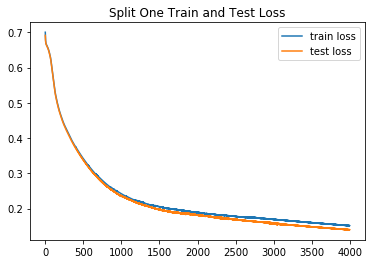

In [63]:
plt.plot(train_curve[0], label='train loss')
plt.plot(test_curve[0], label='test loss')
plt.legend()
plt.title('Split One Train and Test Loss')
plt.show()

In [64]:
def plot_loss(loss_curve, i):
    plt.plot(list(range(len(loss_curve))), loss_curve, label=f'Split {i+1}')

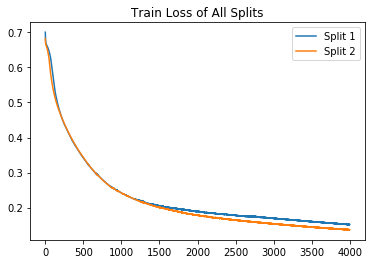

In [65]:
for i, curve in enumerate(train_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Train Loss of All Splits')
plt.show()

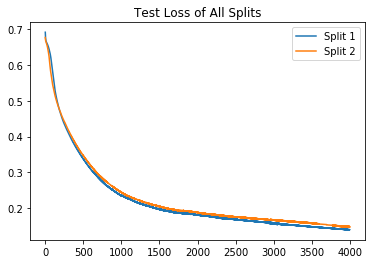

In [66]:
for i, curve in enumerate(test_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Test Loss of All Splits')
plt.show()

#### Comparing Statistical Results for the Models

In [67]:
print("Random Guessing Model F1 Score Mean: ", np.mean(f1_rand))
print("Random Guessing Model F1 Score Standard Deviation: ", np.std(f1_rand), '\n')

print("Random Guessing Model Precision Score Mean: ", np.mean(precision_rand))
print("Random Guessing Model Precision Score Standard Deviation: ", np.std(precision_rand), '\n')

print("Random Guessing Model Accuracy Score Mean: ", np.mean(accuracy_rand))
print("Random Guessing Model Accuracy Score Standard Deviation: ", np.std(accuracy_rand), '\n')

print("Random Guessing Model Recall Score Mean: ", np.mean(recall_rand))
print("Random Guessing Model Recall Score Standard Deviation: ", np.std(recall_rand), '\n')

print("Random Guessing Model ROC AUC Score Mean: ", np.mean(ras_rand))
print("Random Guessing Model ROC AUC Score Standard Deviation: ", np.std(ras_rand))

Random Guessing Model F1 Score Mean:  0.4366753451458393
Random Guessing Model F1 Score Standard Deviation:  0.0010335716488124314 

Random Guessing Model Precision Score Mean:  0.38846088127232925
Random Guessing Model Precision Score Standard Deviation:  0.00010275654946878543 

Random Guessing Model Accuracy Score Mean:  0.4997867963527608
Random Guessing Model Accuracy Score Standard Deviation:  0.000654651596512762 

Random Guessing Model Recall Score Mean:  0.4985606842591094
Random Guessing Model Recall Score Standard Deviation:  0.0025252605128422145 

Random Guessing Model ROC AUC Score Mean:  0.49956596553138705
Random Guessing Model ROC AUC Score Standard Deviation:  0.0009934013722620594


In [68]:
print("Logistic Regression Model F1 Score Mean: ", np.mean(f1_lr))
print("Logistic Regression Model F1 Score Standard Deviation: ", np.std(f1_lr), '\n')

print("Logistic Regression Model Precision Score Mean: ", np.mean(precision_lr))
print("Logistic Regression Model Precision Score Standard Deviation: ", np.std(precision_lr), '\n')

print("Logistic Regression Model Accuracy Score Mean: ", np.mean(accuracy_lr))
print("Logistic Regression Model Accuracy Score Standard Deviation: ", np.std(accuracy_lr), '\n')

print("Logistic Regression Model Recall Score Mean: ", np.mean(recall_lr))
print("Logistic Regression Model Recall Score Standard Deviation: ", np.std(recall_lr), '\n')

print("Logistic Regression Model ROC AUC Score Mean: ", np.mean(ras_lr))
print("Logistic Regression Model ROC AUC Score Standard Deviation: ", np.std(ras_lr))

Logistic Regression Model F1 Score Mean:  0.9291932603089437
Logistic Regression Model F1 Score Standard Deviation:  0.003292585220380062 

Logistic Regression Model Precision Score Mean:  0.9636131239332195
Logistic Regression Model Precision Score Standard Deviation:  0.0005976349312452611 

Logistic Regression Model Accuracy Score Mean:  0.9468303254024868
Logistic Regression Model Accuracy Score Standard Deviation:  0.002443292062799307 

Logistic Regression Model Recall Score Mean:  0.8971613040705109
Logistic Regression Model Recall Score Standard Deviation:  0.005620783011917485 

Logistic Regression Model ROC AUC Score Mean:  0.9378025057878607
Logistic Regression Model ROC AUC Score Standard Deviation:  0.0029648903010615624


In [69]:
print("Random Forest Model F1 Score Mean: ", np.mean(f1_rf))
print("Random Forest Model F1 Score Standard Deviation: ", np.std(f1_rf), '\n')

print("Random Forest Model Precision Score Mean: ", np.mean(precision_rf))
print("Random Forest Model Precision Score Standard Deviation: ", np.std(precision_rf), '\n')

print("Random Forest Model Accuracy Score Mean: ", np.mean(accuracy_rf))
print("Random Forest Model Accuracy Score Standard Deviation: ", np.std(accuracy_rf), '\n')

print("Random Forest Model Recall Score Mean: ", np.mean(recall_rf))
print("Random Forest Model Recall Score Standard Deviation: ", np.std(recall_rf), '\n')

print("Random Forest Model ROC AUC Score Mean: ", np.mean(ras_rf))
print("Random Forest Model ROC AUC Score Standard Deviation: ", np.std(ras_rf), '\n')

Random Forest Model F1 Score Mean:  0.9939755249222182
Random Forest Model F1 Score Standard Deviation:  0.00026241719996822344 

Random Forest Model Precision Score Mean:  0.9888427023826002
Random Forest Model Precision Score Standard Deviation:  0.00033168467784916444 

Random Forest Model Accuracy Score Mean:  0.9952895250109999
Random Forest Model Accuracy Score Standard Deviation:  0.00021573223275955788 

Random Forest Model Recall Score Mean:  0.9991619221182526
Random Forest Model Recall Score Standard Deviation:  0.00019168218415716032 

Random Forest Model ROC AUC Score Mean:  0.9959936231782711
Random Forest Model ROC AUC Score Standard Deviation:  0.00021573848503281257 



In [70]:
print("Gaussian Naive Bayes Model F1 Score Mean: ", np.mean(f1_gnb))
print("Gaussian Naive Bayes Model F1 Score Standard Deviation: ", np.std(f1_gnb), '\n')

print("Gaussian Naive Bayes Model Precision Score Mean: ", np.mean(precision_gnb))
print("Gaussian Naive Bayes Model Precision Score Standard Deviation: ", np.std(precision_gnb), '\n')

print("Gaussian Naive Bayes Model Accuracy Score Mean: ", np.mean(accuracy_gnb))
print("Gaussian Naive Bayes Model Accuracy Score Standard Deviation: ", np.std(accuracy_gnb), '\n')

print("Gaussian Naive Bayes Model Recall Score Mean: ", np.mean(recall_gnb))
print("Gaussian Naive Bayes Model Recall Score Standard Deviation: ", np.std(recall_gnb), '\n')

print("Gaussian Naive Bayes Model ROC AUC Score Mean: ", np.mean(ras_gnb))
print("Gaussian Naive Bayes Model ROC AUC Score Standard Deviation: ", np.std(ras_gnb), '\n')

Gaussian Naive Bayes Model F1 Score Mean:  0.8543748794936488
Gaussian Naive Bayes Model F1 Score Standard Deviation:  0.015394607347629985 

Gaussian Naive Bayes Model Precision Score Mean:  0.869400552873812
Gaussian Naive Bayes Model Precision Score Standard Deviation:  0.02008380402074178 

Gaussian Naive Bayes Model Accuracy Score Mean:  0.8888699734519216
Gaussian Naive Bayes Model Accuracy Score Standard Deviation:  0.007117826409622885 

Gaussian Naive Bayes Model Recall Score Mean:  0.8425673944095754
Gaussian Naive Bayes Model Recall Score Standard Deviation:  0.048664198629246536 

Gaussian Naive Bayes Model ROC AUC Score Mean:  0.8804037019697444
Gaussian Naive Bayes Model ROC AUC Score Standard Deviation:  0.014724646541380726 



In [73]:
print("Neural Network Model F1 Score Mean: ", np.mean(f1_nn))
print("Neural Network Model F1 Score Standard Deviation: ", np.std(f1_nn), '\n')

print("Neural Network Model Precision Score Mean: ", np.mean(precision_nn))
print("Neural Network Model Precision Score Standard Deviation: ", np.std(precision_nn), '\n')

print("Neural Network Model Accuracy Score Mean: ", np.mean(accuracy_nn))
print("Neural Network Model Accuracy Score Standard Deviation: ", np.std(accuracy_nn), '\n')

print("Neural Network Model Recall Score Mean: ", np.mean(recall_nn))
print("Neural Network Model Recall Score Standard Deviation: ", np.std(ras_nn), '\n')

print("Neural Network Model ROC AUC Score Mean: ", np.mean(ras_nn))
print("Neural Network Model ROC AUC Score Standard Deviation: ", np.std(ras_nn), '\n')

Neural Network Model F1 Score Mean:  0.9468956989420629
Neural Network Model F1 Score Standard Deviation:  0.0013924193451505529 

Neural Network Model Precision Score Mean:  0.9473098979392984
Neural Network Model Precision Score Standard Deviation:  0.0007454063635831121 

Neural Network Model Accuracy Score Mean:  0.9587143709888767
Neural Network Model Accuracy Score Standard Deviation:  0.0011439643510382513 

Neural Network Model Recall Score Mean:  0.946482745544179
Neural Network Model Recall Score Standard Deviation:  0.001292750487840777 

Neural Network Model ROC AUC Score Mean:  0.9564912825724596
Neural Network Model ROC AUC Score Standard Deviation:  0.001292750487840777 



In [91]:
resultdf = pd.DataFrame(columns=['Classifiers', 'F1 Score', 'Accuracy Score', 'Precision Score', 'Recall Score', 'ROC AUC Score'])

resultdf.loc[0] = 'Random Guessing', np.mean(f1_rand), np.mean(accuracy_rand), np.mean(precision_rand), np.mean(recall_rand),  np.mean(ras_rand)
resultdf.loc[1] = 'Logistic Regression', np.mean(f1_lr), np.mean(accuracy_lr), np.mean(precision_lr), np.mean(recall_lr),  np.mean(ras_lr)
resultdf.loc[2] = 'Neural Network', np.mean(f1_nn), np.mean(accuracy_nn), np.mean(precision_nn), np.mean(recall_nn),  np.mean(ras_nn)
resultdf.loc[3] = 'Random Forest', np.mean(f1_rf), np.mean(accuracy_rf), np.mean(precision_rf), np.mean(recall_rf),  np.mean(ras_rf)
resultdf.loc[4] = 'Gaussian Naive Bayes ', np.mean(f1_gnb), np.mean(accuracy_gnb), np.mean(precision_gnb), np.mean(recall_gnb),  np.mean(ras_gnb)

resultdf

,Classifiers,F1 Score,Accuracy Score,Precision Score,Recall Score,ROC AUC Score
0,Random Guessing,0.436675,0.499787,0.388461,0.498561,0.499566
1,Logistic Regression,0.929193,0.946830,0.963613,0.897161,0.937803
2,Neural Network,0.946896,0.958714,0.947310,0.946483,0.956491
3,Random Forest,0.993976,0.995290,0.988843,0.999162,0.995994
4,Gaussian Naive Bayes,0.854375,0.888870,0.869401,0.842567,0.880404


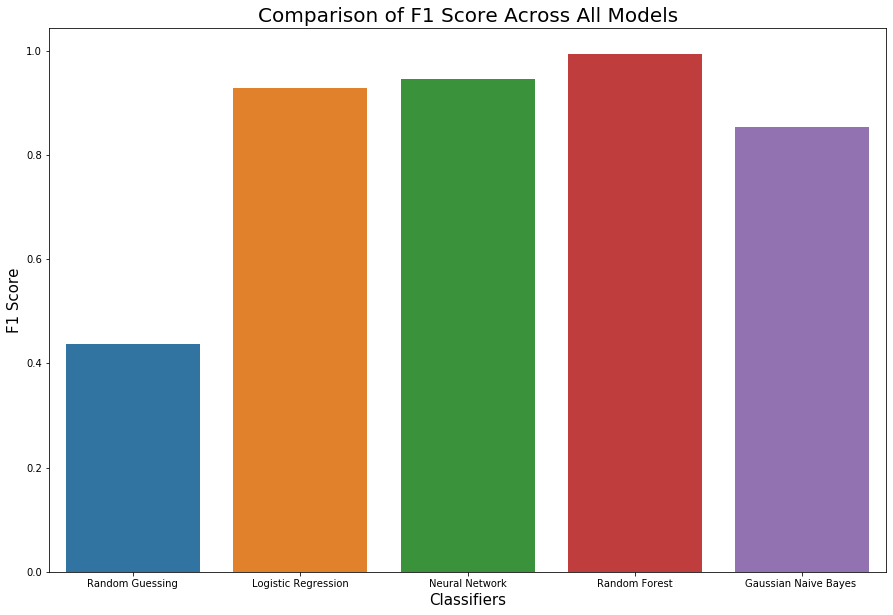

In [92]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='F1 Score')
plt.title('Comparison of F1 Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("F1 Score", fontsize=15)
plt.show()

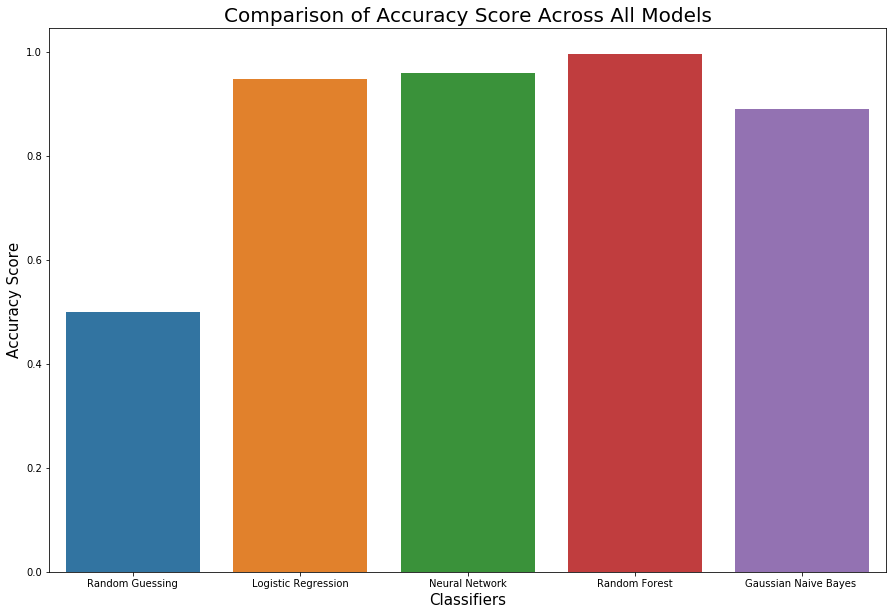

In [93]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Accuracy Score')
plt.title('Comparison of Accuracy Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.show()

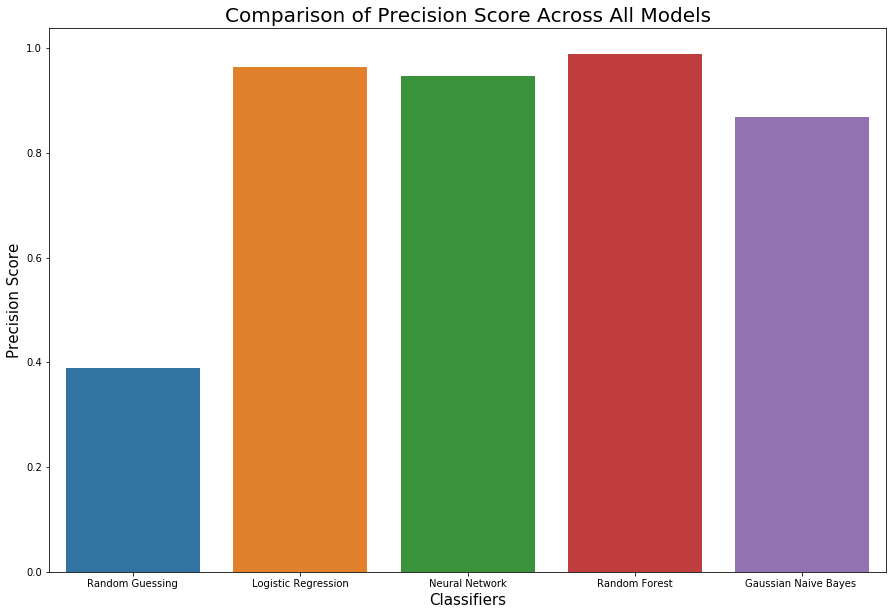

In [94]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Precision Score')
plt.title('Comparison of Precision Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Precision Score", fontsize=15)
plt.show()

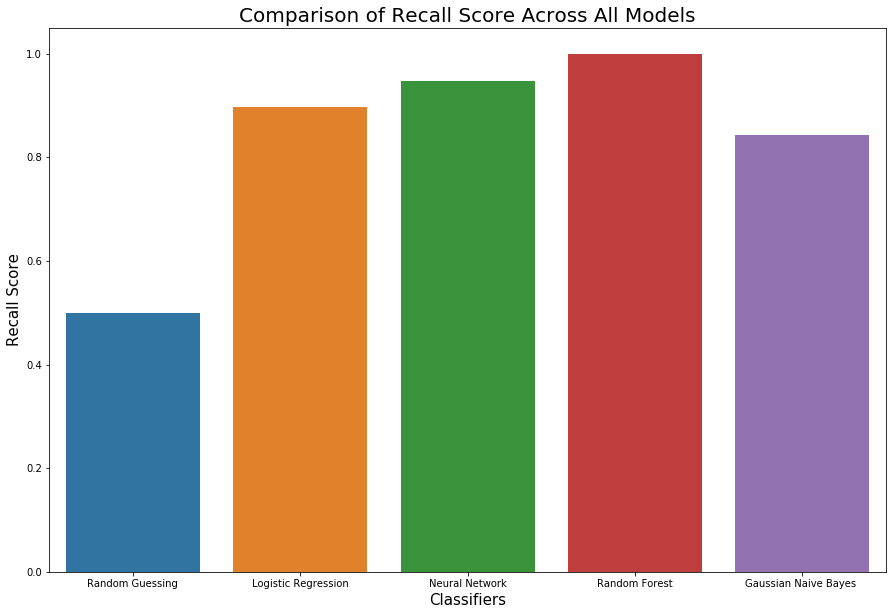

In [95]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Recall Score')
plt.title('Comparison of Recall Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Recall Score", fontsize=15)
plt.show()

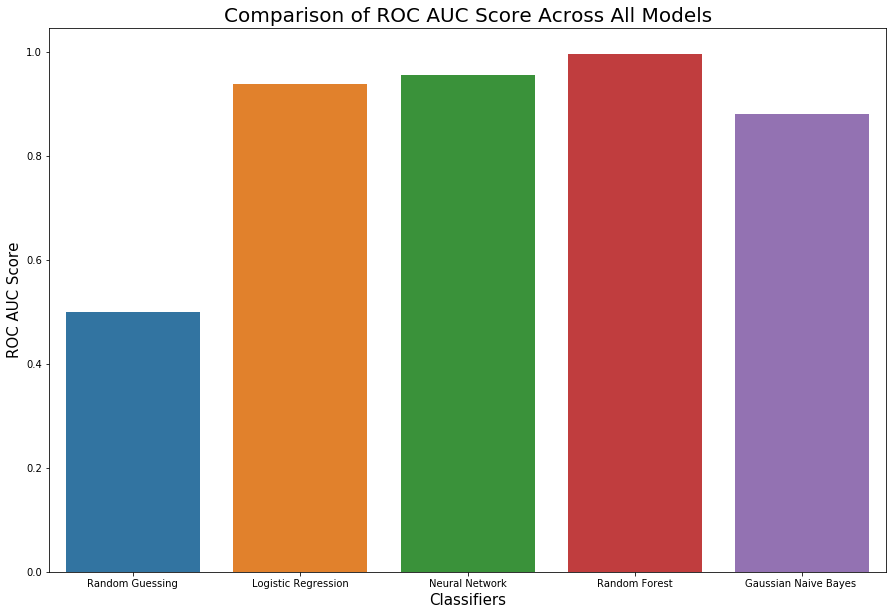

In [96]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='ROC AUC Score')
plt.title('Comparison of ROC AUC Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("ROC AUC Score", fontsize=15)
plt.show()

#### Intermediary Workings of the Neural Network

In [ ]:
X_transformed = th.tensor(x, dtype=th.float32)
representations = nn1.get_intermediary(X_transformed)
representations = representations.detach().numpy()

In [ ]:
colors = np.array(['tab:red' if cl == 0 else 'tab:blue' for cl in y])
plt.scatter(representations[:,0], representations[:,1], c=colors)